# **Hybrid ML/NLP Stock Direction Predictor – Classical Prototype**
This notebook implements a classical SVM model for next-day stock price direction prediction, augmented with sentiment features from financial news using a transformer-based model. The workflow demonstrates end-to-end financial ML pipelines, including time-series feature engineering, macroeconomic indicators, NLP integration, and reproducible evaluation with simple backtesting. Designed for Colab and ready for exploration or extension to hybrid ML/quant workflows.

Install libraries:

In [51]:
# Install required packages
!pip install yfinance fredapi nltk transformers datasets --quiet

In [52]:
# Import libraries
# Data handling
import pandas as pd
import numpy as np
import yfinance as yf
from fredapi import Fred
import nltk

# Machine learning
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# NLP
from transformers import pipeline

# Visualisation
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# NLTK setup
nltk.download('vader_lexicon', quiet=True)

True

Define API keys and download stock data:

In [53]:
# Define API keys (required for FRED)
FRED_API_KEY = 'your-FRED-API-KEY-here'  # Replace with your own
fred = Fred(api_key=FRED_API_KEY)

ticker = 'AAPL'
stock_data = yf.download(ticker, start='2020-01-01', end='2024-01-01', auto_adjust=True)

# Flatten MultiIndex if present
if isinstance(stock_data.columns, pd.MultiIndex):
    stock_data.columns = ['_'.join([str(i) for i in col if i]).strip() for col in stock_data.columns.values]

# Rename key columns for convenience
rename_map = {}
for col in stock_data.columns:
    if 'Close' in col:
        rename_map[col] = 'Close'
    elif 'Volume' in col:
        rename_map[col] = 'Volume'
stock_data.rename(columns=rename_map, inplace=True)

# Safety check
required_cols = ['Close', 'Volume']
for c in required_cols:
    if c not in stock_data.columns:
        raise KeyError(f"Required column '{c}' not found after renaming: {stock_data.columns}")

[*********************100%***********************]  1 of 1 completed


Feature engineering:

In [54]:
# Feature engineering – technical indicators
stock_data['MA10'] = stock_data['Close'].rolling(window=10).mean()
stock_data['MA50'] = stock_data['Close'].rolling(window=50).mean()
stock_data['Return'] = stock_data['Close'].pct_change()
stock_data['Volatility'] = stock_data['Return'].rolling(window=10).std()

Add macroeconomic indicator:

In [55]:
try:
    # Fetch monthly 10-Year Treasury Rate from FRED
    interest_rate = fred.get_series('GS10')

    # Resample to daily frequency and forward-fill missing values
    interest_rate = interest_rate.resample('D').ffill()
    interest_rate.name = 'InterestRate'
    interest_rate = interest_rate.to_frame()

    # Merge with stock_data on Date
    stock_data = stock_data.reset_index()  # Ensure 'Date' is a column
    stock_data = stock_data.merge(interest_rate, how='left', left_on='Date', right_index=True)

    # Fill any remaining missing values
    stock_data['InterestRate'] = stock_data['InterestRate'].ffill().fillna(0)

    print("Step 4: Successfully retrieved FRED interest rates.")

except Exception as e:
    # Fallback if FRED fails
    stock_data['InterestRate'] = 0
    print("Step 4: FRED API failed or connection error. Using 0 for interest rates.")

Step 4: Successfully retrieved FRED interest rates.


Prepare transformer sentiment analysis pipeline:

In [56]:
# Prepare transformer sentiment analysis pipeline
# Step 5: Prepare transformer sentiment analysis pipeline
from transformers import pipeline

# Load a pre-trained transformer for sentiment analysis
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english"
)

Device set to use cpu


Prepare financial news headlines:

In [57]:
# Step 6: Example financial news headlines mapped by date
news_data = {
    '2023-11-20': "Apple reports record revenue driven by strong iPhone sales.",
    '2023-11-21': "Supply chain disruptions impact Apple’s quarterly performance.",
    '2023-11-22': "Analysts optimistic about Apple's new product launches.",
    '2023-11-23': "Apple faces lawsuit over app store policies.",
    '2023-11-24': "Strong holiday season expected to boost Apple sales.",
    # Extend or replace with real daily headlines for better accuracy
}

# Convert dictionary into a DataFrame
news_df = pd.DataFrame(list(news_data.items()), columns=['Date', 'Headline'])

# Ensure 'Date' column is in datetime format for proper merging later
news_df['Date'] = pd.to_datetime(news_df['Date'])

Prepare sentiment scores for financial news headlines:

In [58]:
# Step 7: Compute sentiment scores for headlines
def compute_sentiment(text):
    result = sentiment_pipeline(text)[0]  # Run transformer pipeline
    score = result['score']                # Probability/confidence of the label
    return score if result['label'] == 'POSITIVE' else -score  # Positive -> +score, Negative -> -score

# Apply to every headline
news_df['SentimentScore'] = news_df['Headline'].apply(compute_sentiment)

# Merge sentiment scores into the stock_data by date
stock_data = stock_data.merge(news_df[['Date', 'SentimentScore']], on='Date', how='left') # NLP text converted to a numerical feature ('SentimentScore') for SVM

# Fill any missing values (e.g., days without news)
stock_data['SentimentScore'] = stock_data['SentimentScore'].fillna(method='ffill').fillna(0)

/tmp/ipython-input-4157536888.py:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data['SentimentScore'] = stock_data['SentimentScore'].fillna(method='ffill').fillna(0)


Define target variable for SVM (next day price movement):

In [59]:
# Define target variable for SVM: next-day price movement
# 1 = price goes up, 0 = price goes down or stays the same
stock_data['Target'] = (stock_data['Return'].shift(-1) > 0).astype(int)

# Clean dataset by dropping rows with any NaN values (e.g., from rolling calculations or merges)
stock_data = stock_data.dropna()

Prepare feature matrix and target vector:

In [60]:
# Prepare Features & Target
# Define feature columns for the SVM
features = ['MA10', 'MA50', 'Volatility', 'Volume', 'InterestRate', 'SentimentScore']

# Feature matrix (X) and target vector (y)
X = stock_data[features]       # Input features
y = stock_data['Target']       # Labels

# Scale Features
# Standardise features to zero mean and unit variance for SVM
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split Train/Test Sets
# Use chronological split (shuffle=False) for time-series integrity
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, shuffle=False
)

# Train SVM Classifier
# RBF kernel, standard regularisation parameters
clf = SVC(kernel='rbf', C=1.0, gamma='auto')
clf.fit(X_train, y_train)

print("SVM classifier trained on historical data.")

SVM classifier trained on historical data.


Make predictions and evaluate model. This step shows how well the SVM model, using technical, macroeconomic, and NLP-derived features, performs on unseen data:

- classification_report gives precision, recall, f1-score, and support for each class (Up vs Down).
- accuracy_score gives a simple overall correctness metric.
- could also add confusion matrices or other metrics if you want to visualize model performance further.

In [61]:
# Make Predictions & Evaluate Model

# Predict next-day price direction on test set
y_pred = clf.predict(X_test)

# Print detailed classification metrics
print("Classification Report:\n", classification_report(y_test, y_pred))

# Print overall accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)


Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.83      0.58        88
           1       0.46      0.12      0.20       104

    accuracy                           0.45       192
   macro avg       0.45      0.48      0.39       192
weighted avg       0.46      0.45      0.37       192

Accuracy: 0.4479166666666667


Visualise actual vs predicted price movement:

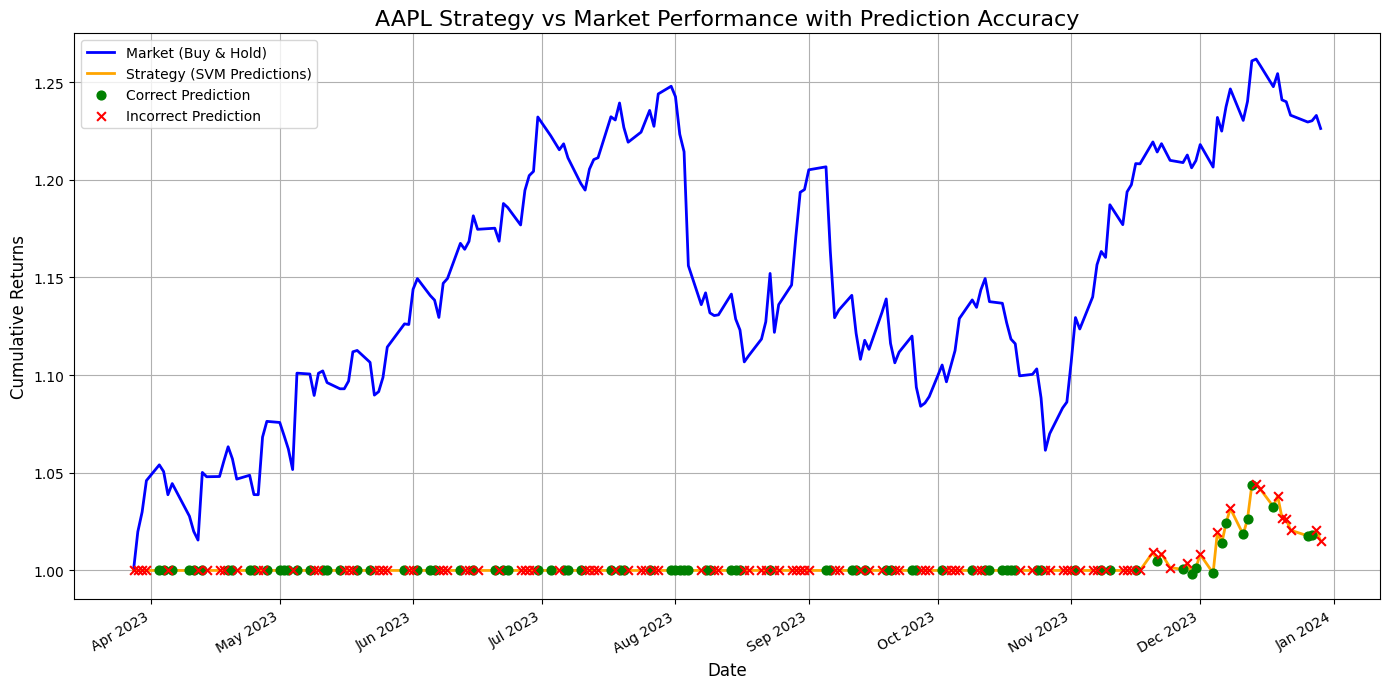

In [62]:
# Compute daily returns for test period
stock_data_test = stock_data.iloc[-len(y_test):].copy()
stock_data_test['PredictedSignal'] = y_pred
stock_data_test['DailyReturn'] = stock_data_test['Close'].pct_change().fillna(0)

# Strategy returns and cumulative returns
stock_data_test['StrategyReturn'] = stock_data_test['DailyReturn'] * stock_data_test['PredictedSignal']
stock_data_test['CumulativeStrategy'] = (1 + stock_data_test['StrategyReturn']).cumprod()
stock_data_test['CumulativeMarket'] = (1 + stock_data_test['DailyReturn']).cumprod()

# Determine correct and incorrect predictions
correct_pred = (y_test.values == y_pred)
incorrect_pred = ~correct_pred
dates = stock_data_test['Date']

# Plot
plt.figure(figsize=(14, 7))

# Plot cumulative returns
plt.plot(dates, stock_data_test['CumulativeMarket'], label='Market (Buy & Hold)', color='blue', linewidth=2)
plt.plot(dates, stock_data_test['CumulativeStrategy'], label='Strategy (SVM Predictions)', color='orange', linewidth=2)

# Highlight correct predictions
plt.scatter(dates[correct_pred], stock_data_test['CumulativeStrategy'][correct_pred],
            color='green', marker='o', label='Correct Prediction', s=40, zorder=5)

# Highlight incorrect predictions
plt.scatter(dates[incorrect_pred], stock_data_test['CumulativeStrategy'][incorrect_pred],
            color='red', marker='x', label='Incorrect Prediction', s=40, zorder=5)

# Format x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gcf().autofmt_xdate()

# Labels and title
plt.title(f'{ticker} Strategy vs Market Performance with Prediction Accuracy', fontsize=16)
plt.ylabel('Cumulative Returns', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

**Plot Interpretation – Strategy vs Market Performance**

Orange Line – Strategy Cumulative Returns:

This line shows the hypothetical performance of a portfolio following your SVM predictions:

- When the model predicts the stock will go up (y_pred = 1), you “invest” in the stock for that day.
- When the model predicts a down day (y_pred = 0), you stay in cash (0% invested).
- The line is cumulative, multiplying each day’s return by the previous capital.
- Even though the predictions are binary, the cumulative line appears smooth because it reflects actual daily returns scaled by the predicted signal.

Blue Line – Market Cumulative Returns:

This represents the baseline performance if you were fully invested in the stock every day, ignoring the model.

- Calculated as (1 + daily stock return).cumprod().
- Serves as a reference to see if your strategy adds value compared to simply holding the stock.

Markers – Prediction Accuracy:

- Green circles: Days where the model correctly predicted the stock’s direction.
- Red crosses: Days where the model’s prediction was incorrect.
- These markers help visually correlate strategy performance with prediction reliability.